## Amanda Rudolph  | Project Status Report | Analysis Update

In [45]:
pip install sodapy

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## RQ #1: *Are there systematic differences in food inspection ratings by restaurant-types, especially those in neighborhoods with a higher proportion of non-white residents?*

### Prepping Inspections Data

Data Cleaning:

In [47]:
from sodapy import Socrata
client = Socrata("data.cityofchicago.org", None)
results = client.get("4ijn-s7e5", limit=40000)
inspections_data = pd.DataFrame.from_records(results)

In [49]:
#Getting information about the dataframes structure and determining which columns to drop
#I am dropping columns I don't need for analysis, such as the columns that give me exact locations I only need the zipcode
inspections_data.info()
inspections_data = inspections_data.drop(columns=['inspection_id','license_', 'address', 'aka_name', 'city', 'state', 'latitude', 'longitude', 'location', ':@computed_region_awaf_s7ux', ':@computed_region_6mkv_f3dw', ':@computed_region_vrxf_vc4k', ':@computed_region_bdys_3d7i', ':@computed_region_43wa_7qmu'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   inspection_id                40000 non-null  object
 1   dba_name                     40000 non-null  object
 2   aka_name                     39897 non-null  object
 3   license_                     40000 non-null  object
 4   facility_type                39764 non-null  object
 5   risk                         39990 non-null  object
 6   address                      40000 non-null  object
 7   city                         39947 non-null  object
 8   state                        39983 non-null  object
 9   zip                          39967 non-null  object
 10  inspection_date              40000 non-null  object
 11  inspection_type              40000 non-null  object
 12  results                      40000 non-null  object
 13  violations                   27

In [50]:
inspections_data.head()
#Cleaned up version of inspections data with unnecessary columns dropped

,dba_name,facility_type,risk,zip,inspection_date,inspection_type,results,violations
0,JUNIOR CHEFS KITCHEN,School,Risk 1 (High),60614,2023-11-14T00:00:00.000,License,Fail,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...
1,THOREK MEMORIAL HOSPITAL,Restaurant,Risk 1 (High),60613,2023-11-14T00:00:00.000,Canvass,Pass w/ Conditions,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED...
2,BARRACO'S PIZZA AND THE VINEYARD BANQUETS,Restaurant,Risk 1 (High),60643,2023-11-13T00:00:00.000,Complaint,Pass,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ..."
3,"PALETERIAS MONARCA, CORP.",Restaurant,Risk 1 (High),60626,2023-11-13T00:00:00.000,Canvass,Out of Business,NaN
4,YOUR BUDZ,Restaurant,Risk 2 (Medium),60613,2023-11-13T00:00:00.000,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E..."


In [51]:
#The .info() function also told me what datatypes I am working with
#Converting the datatypes of zipcode (I need integer values)
#Converting the datatype of "inspection date". Datetime object will be more helpful
inspections_data = inspections_data.dropna(subset='zip')
inspections_data['zip'] = inspections_data['zip'].astype(int)
inspections_data['inspection_date'] = pd.to_datetime(inspections_data['inspection_date'])


In [52]:
inspections_data.info()
#Checking that I now have zip codes that are integers
#Checking that I have inspection dates that are datetime values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39967 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   dba_name         39967 non-null  object        
 1   facility_type    39735 non-null  object        
 2   risk             39958 non-null  object        
 3   zip              39967 non-null  int64         
 4   inspection_date  39967 non-null  datetime64[ns]
 5   inspection_type  39967 non-null  object        
 6   results          39967 non-null  object        
 7   violations       27751 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 2.7+ MB


##### My research question only focuses on restaurants. I want to look into the values within the "facility type" column to see how they correspond with my RQ.

In [53]:
inspections_data['facility_type'].value_counts()
#Values associated with "facility types" and how many of them there are

Restaurant                                27771
Grocery Store                              3927
School                                     2747
Children's Services Facility               1336
Daycare Above and Under 2 Years             658
                                          ...  
CULINARY CLASS ROOMS                          1
DELI/BAKERY                                   1
Airport Lounge                                1
BREWPUB                                       1
A-Not-For-Profit Chef Training Program        1
Name: facility_type, Length: 178, dtype: int64

##### I am interested in looking at the food inspection ratings of restaurants, but not of other facilities. I am going to limit the dataset to only show restaurants. The highest number of entries in the inspections dataset are for restaurnts, so I know i still have a lot of data to analyze for my RQ.

In [54]:
inspections_data_restaurants = inspections_data[inspections_data['facility_type']=='Restaurant']
inspections_data_restaurants = inspections_data_restaurants.drop(columns='facility_type')
#Limiting dataset to only restaurants
#Dropping column for facility type as I now know every facility is a restaurant

##### The "facility type" column also shows me that I have knowledge of which facilities are restuarnts, but not what *type* of restaurants each is or what kind of food is being served. I need to modify my research question since I do not have this information available.



## Modified RQ1: *Are there systematic differences in food inspection ratings in neighborhoods with a higher proportion of non-white residents?*


##### My RQ focuses on food inspection ratings, or the "results" of food inspections. I want to look at the values of this column to understand the different outcomes.

In [55]:
#Observing the number of times each different result came up 
#7 different results, but I am only interested in inspections that had pass or failing outcomes.
inspections_data_restaurants['results'].value_counts()

#Dropping entries that are not necessary for analysis
inspections_data_restaurants = inspections_data_restaurants[inspections_data_restaurants['results']!='No Entry']
inspections_data_restaurants = inspections_data_restaurants[inspections_data_restaurants['results']!='Out of Business']
inspections_data_restaurants = inspections_data_restaurants[inspections_data_restaurants['results']!='Not Ready']
inspections_data_restaurants = inspections_data_restaurants[inspections_data_restaurants['results']!='Business Not Located']

##### What does the distribution pattern of these results look like? I am curious if the majority of restaurants pass or fail. This will give me a better idea what my next steps will entail.

In [56]:
#Instead of having the number of inspections that have each result, I am finding percentages
#I see that the majority of restaurants pass inspections (55%),24.7% fail, and 19.69 pass w/ conditions
inspections_data_restaurants['results'].value_counts() * 100 / len(inspections_data_restaurants)


Pass                  55.531349
Fail                  24.774520
Pass w/ Conditions    19.694131
Name: results, dtype: float64

### Prepping the demographics data

Data Cleaning:

In [57]:
demographic_data = pd.read_csv('https://data.cityofchicago.org/resource/85cm-7uqa.csv')

In [59]:
#By looking at the dataframe, it is clear that there are several columns that will not be helpful to my analysis
#I only need the zipcode for location, and ethnic/racial group. I am not interested in age groups. 
demographic_data = demographic_data.drop(columns=['geography_type', 'record_id', 'population_female', 'population_male', 'population_age_0_17', 'population_age_18_29', 'population_age_30_39', 'population_age_40_49', 'population_age_50_59', 'population_age_60_69', 'population_age_70_79', 'population_age_80', 'population_age_0_4', 'population_age_5_11', 'population_age_12_17', 'population_age_5_', 'population_age_18_', 'population_age_65_'])

In [60]:
#The dataset also contains demographic information from outside of Chicago
#Limiting dataframe to only show Chicago
demographic_data = demographic_data[demographic_data['geography']!='Chicago']

#Dataset has data from several years
#Limiting dataframe to only show data from 2021
demographic_data2021 = demographic_data[demographic_data['year']==2021]

#Since I now know my dataset only includes data from 2021, the year column is not necessary
#Dropping 'year' column
demographic_data2021 = demographic_data2021.drop(columns='year')

In [61]:
demographic_data2021.head()
#Demographic data from 2021

,geography,population_total,population_latinx,population_asian_non_latinx,population_black_non_latinx,population_white_non_latinx,population_other_race_non
176,60601,14804,1234,3827.0,908.0,8124,711.0
177,60602,1142,311,101.0,38.0,537,155.0
178,60603,1275,78,397.0,71.0,723,6.0
179,60604,687,30,70.0,72.0,515,0.0
180,60605,32077,2841,4942.0,4571.0,18296,1427.0


In [62]:
#When looking at the demographic_data2021 df, I noticed that there was a zipcode with 0 population
#The zipcode is '60666' and is solely for O'Hare Airpoty. No one lives here.
#Dropping this record from the dataset
demographic_data2021 = demographic_data2021[demographic_data2021['geography']!='60666']
inspections_data_restaurants = inspections_data_restaurants[inspections_data_restaurants['zip']!='60666']

In [63]:
#Getting information about the dataframes structure
#Making sure values are in types that will be useful for analysis
demographic_data2021.info()

#I want the zipcodes ('geography column') and populations to be integers for future manipluation
#Changing data type
demographic_data2021['geography'] = demographic_data2021['geography'].astype(int)
demographic_data2021['population_asian_non_latinx'] = demographic_data2021['population_asian_non_latinx'].astype(int)
demographic_data2021['population_black_non_latinx'] = demographic_data2021['population_black_non_latinx'].astype(int)
demographic_data2021['population_other_race_non'] = demographic_data2021['population_other_race_non'].astype(int)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 176 to 234
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geography                    58 non-null     object 
 1   population_total             58 non-null     int64  
 2   population_latinx            58 non-null     int64  
 3   population_asian_non_latinx  58 non-null     float64
 4   population_black_non_latinx  58 non-null     float64
 5   population_white_non_latinx  58 non-null     int64  
 6   population_other_race_non    58 non-null     float64
dtypes: float64(3), int64(3), object(1)
memory usage: 3.6+ KB


##### Now that I have the demographic_data2021 cleaned up, I want to continue to make the data more useful. Determining the percentage of people that fit into the demographic groups is my first step.

In [64]:
#Determining percentage of people that fit into these categories out of the total population

demographic_data2021['population_latinx'] = demographic_data2021['population_latinx']*100/demographic_data2021['population_total']
demographic_data2021['population_asian_non_latinx'] = demographic_data2021['population_asian_non_latinx']*100/demographic_data2021['population_total']
demographic_data2021['population_black_non_latinx'] = demographic_data2021['population_black_non_latinx']*100/demographic_data2021['population_total']
demographic_data2021['population_white_non_latinx'] = demographic_data2021['population_white_non_latinx']*100/demographic_data2021['population_total']
demographic_data2021['population_other_race_non'] = demographic_data2021['population_other_race_non']*100/demographic_data2021['population_total']

In [65]:
#Here is my modified datset that now includes the demographic totals calculated above
demographic_data2021.head()


,geography,population_total,population_latinx,population_asian_non_latinx,population_black_non_latinx,population_white_non_latinx,population_other_race_non
176,60601,14804,8.335585,25.851121,6.133477,54.877060,4.802756
177,60602,1142,27.232925,8.844133,3.327496,47.022767,13.572680
178,60603,1275,6.117647,31.137255,5.568627,56.705882,0.470588
179,60604,687,4.366812,10.189229,10.480349,74.963610,0.000000
180,60605,32077,8.856813,15.406678,14.250086,57.037753,4.448670


##### Now that my inspection and demographic data is prepared, I am starting the analysis.

# Analysis

### Aggregate Inspections by Zip Code

##### I want to see the distribution of inspection outcomes bt zip code. This will prepare me to merge the demographic data with inspections data since I am planning to merge them both on zipcode. This is the column they both have in common.

In [66]:
#Grouping by zip code to see how many inspections correspond to each outcome
#Putting outcomes from this into a dataframe
inspections_by_zip = inspections_data_restaurants.groupby('zip')['results'].value_counts().unstack()

In [67]:
#Calculating the sum of inspections for each zip code
#Adding these values to a column in the inspections_zip dataframe
inspections_by_zip['n_inspections'] = inspections_by_zip.sum(axis=1)

In [68]:
inspections_by_zip.head()

results,Fail,Pass,Pass w/ Conditions,n_inspections
zip,,,,
60601,49,261,107,417
60602,36,106,43,185
60603,45,138,67,250
60604,36,105,32,173
60605,187,274,76,537


##### To make sense of these numbers of inspections, I am transforming the number of inspections from a raw number to a percentage

In [69]:
#Converting # of inspections to percentages
inspections_by_zip['Fail'] = inspections_by_zip['Fail']*100/inspections_by_zip['n_inspections']
inspections_by_zip['Pass'] = inspections_by_zip['Pass']*100/inspections_by_zip['n_inspections']
inspections_by_zip['Pass_w_conditions'] = inspections_by_zip['Pass w/ Conditions']*100/inspections_by_zip['n_inspections']
# inspections_by_zip = inspections_by_zip.drop(columns=['Pass w/ Conditions'])

#Resetting the index so that it is no longer the zip code
inspections_by_zip = inspections_by_zip.reset_index()

In [70]:
#The dataframe is now updated
#Shows the total number of inspections and percentages of each inspection outcome by zipcode
inspections_by_zip.head()

results,zip,Fail,Pass,Pass w/ Conditions,n_inspections,Pass_w_conditions
0,60601,11.750600,62.589928,107,417,25.659472
1,60602,19.459459,57.297297,43,185,23.243243
2,60603,18.000000,55.200000,67,250,26.800000
3,60604,20.809249,60.693642,32,173,18.497110
4,60605,34.823091,51.024209,76,537,14.152700


In [71]:
#One row in the dataframe stood out as it only had 7 inspections
#I see 57% fail rate, almost twice as much as other rows. Outliars are likely
#These averages wont be helpful
#Making decision to drop any zipcodes with fewer than 10 inspections.
inspections_by_zip = inspections_by_zip[inspections_by_zip['n_inspections']>10]


##### Now that the inspections are aggregated by zipcode, I am ready to merge the inspections data set with the demographics data set.

## Merging Inspections and Demographics Dataframes

With the outcomes of inspections for each zip code, I can bring in the demographic dataset to start to answer RQ1.

**Inspections dataset**: Tells us the rates of different inspection outcomes for each zip code

**Demographic dataset**: Tells us the rates of different demographic groups that live in each zip code

Merging these 2 datasets will allow to see inspection outcomes and the demographic populations connected to one another for each zip code. To complete this merge, I only want to focus on zip codes where I have data about both inspections and demographics.

In [72]:
#Merging both dfs: inspections by zip code as left dataset, demographic data as right
#Using inner join because this restricts me to zip codes that both dataframes have
#'zip' and 'geography' both contain zip codes
inspections_by_zip_demo = pd.merge(left=inspections_by_zip,right=demographic_data2021,left_on='zip',right_on='geography',how='inner')

In [73]:
inspections_by_zip_demo.head()

,zip,Fail,Pass,Pass w/ Conditions,n_inspections,Pass_w_conditions,geography,population_total,population_latinx,population_asian_non_latinx,population_black_non_latinx,population_white_non_latinx,population_other_race_non
0,60601,11.750600,62.589928,107,417,25.659472,60601,14804,8.335585,25.851121,6.133477,54.877060,4.802756
1,60602,19.459459,57.297297,43,185,23.243243,60602,1142,27.232925,8.844133,3.327496,47.022767,13.572680
2,60603,18.000000,55.200000,67,250,26.800000,60603,1275,6.117647,31.137255,5.568627,56.705882,0.470588
3,60604,20.809249,60.693642,32,173,18.497110,60604,687,4.366812,10.189229,10.480349,74.963610,0.000000
4,60605,34.823091,51.024209,76,537,14.152700,60605,32077,8.856813,15.406678,14.250086,57.037753,4.448670


##### The dataframes have been merged succesfully into the "inspections_by_zip_demo" dataframe. I can start analyzing inspection outcomes by demographics.

## Analyze Inspection Outcomes by Demographics

##### I want to visualize how the inspection fail rate changes as the population of the majority, or the White non-Latinx group increases.

In [1]:
#Creating a plot where each dot represents a zip code and the linear regression line will show a trend 

sns.regplot(x='population_white_non_latinx',y='Fail',data=inspections_by_zip_demo)
plt.title('Fail Rate as Proportion of White Non_Latinx Demographic Changes')
plt.show()

NameError: name 'sns' is not defined

##### This plot shows a gradual downward sloping trend. As a neighborhood has a higher proportion of white residents, there are more restaurants passing inspections.

##### A simple linear regression analysis that takes the fail rate as a function of the white non-latinx population will further demonstrate the relationship seen in the visualization above.

In [75]:
#Linear regression model.
#Dependent variable is the fail rate ('Fail')
#Independent variable is the white non-Latinx population
results = smf.ols('Fail ~ population_white_non_latinx', data=inspections_by_zip_demo).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Fail   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     12.60
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           0.000799
Time:                        23:10:13   Log-Likelihood:                -173.15
No. Observations:                  57   AIC:                             350.3
Df Residuals:                      55   BIC:                             354.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### The values seen in this regression analysis suggest a significant negative relationship between the white non-Latinx population and failure rate. 

Given the negative coefficient (-0.092) and the low p-value (0.001 < 0.05), I can interpret the results: There is a statistically significant negative relationship between the rate of inspection failure ('Fail') and the rate of the white non-Latinx population. As the white non-Latinx population increases, the rate of inspection failure tends to decrease.

### As a neighborhood has a higher proportion of non-white residents, rate of inspection failure may increase. 

Progress has been made towards RQ1, however I still need to analyze further.

1. I am currently working with 3 outcomes (Pass, Fail, and Pass w/ Conditions). Are pass and pass w/ conditions the same outcome?


2. How can I better understand the relationship between neighborhood demographics and inspection outcomes? How will breaking down the different demographic groups impact my answer to RQ1?

## Measuring Pass Rate

###### Determining if I should group the "Pass" and "Pass w/ Conditionns" outcomes together:

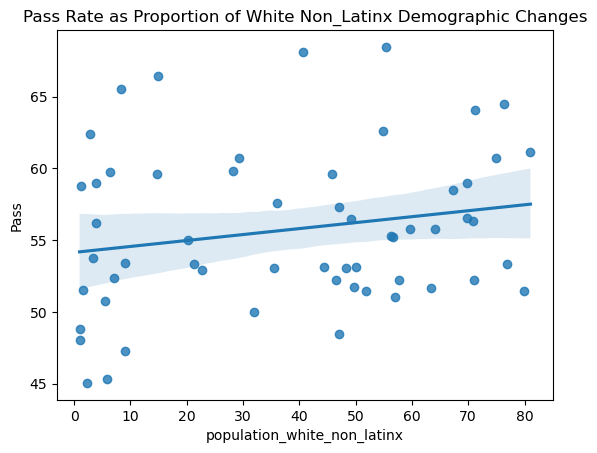

In [77]:
#Completing analysis I did with the white non-Latinx population and fail rate with the pass rate instead
sns.regplot(x='population_white_non_latinx',y='Pass',data=inspections_by_zip_demo)
plt.title('Pass Rate as Proportion of White Non_Latinx Demographic Changes')
plt.show()

 ##### This plot shows a gradual upward sloping trend. As a neighborhood has a higher proportion of white residents, there are more restaurants passing inspections.

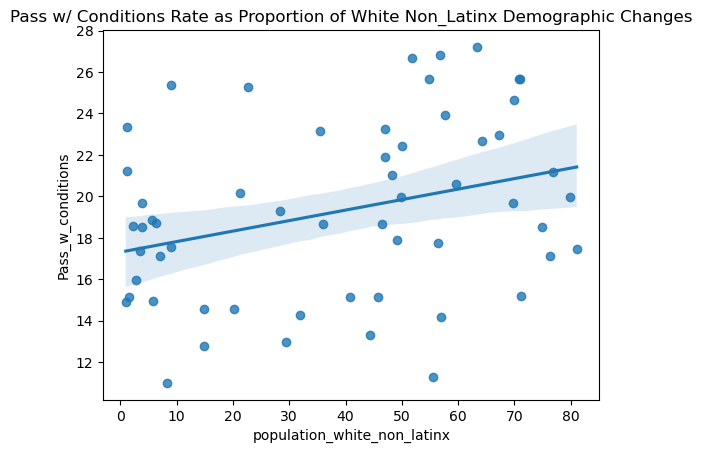

In [80]:
#Completing analysis I did with the white non-Latinx population and fail rate with the pass w/ conditions rate instead
sns.regplot(x='population_white_non_latinx',y='Pass_w_conditions',data=inspections_by_zip_demo)
plt.title('Pass w/ Conditions Rate as Proportion of White Non_Latinx Demographic Changes')
plt.show()
#I am seeing a similiar relationship (positive) with the the "pass by conditions" outcome. 
#It seems that pass and pass by conditions are following pretty similar patterns
#Both are showing a similar positive relationship with percent of white non latinx population

##### I am seeing a similar relationship (positive) with the "pass w/ conditons" outcome. It seems that pass & pass w/ conditions are following similar patterns. Both show a positibve relationship with the percentage of the white non-Latinx population. 

##### While I have initial reason to beleive pass and pass w/ conditions have similar patterns, I want to analyze further to determine if I can treat these groups as the same. Splitting neighborhoods into 2 groups (one where the majority of the neighborhood is the white non-Latinx population and one where it is not), I can calculate the outcome rates to support my decision.

### Splitting Neighborhoods into 2 Groups: Majority white non-Latinx vs Minority white non-Latinx

In [82]:
#Creating a majority_minority column that will indicate whether the majorirty or minority of the population is white non-latinx
#Classifying zip codes by based on if population is greater or less than 50%
#Above 50% indicates majority, below indicates minority
inspections_by_zip_demo['majority_minority'] = inspections_by_zip_demo['population_white_non_latinx']<50

In [84]:
#Creating a dataframe that shows majority_minority with True & False values
#False: Zip Code where the minority is white non-Latinx
#True: Zip codes where the majority is white non-Latinx
outcomes_by_maj_min = inspections_by_zip_demo.groupby('majority_minority').aggregate(
    fail_rate = ('Fail', pd.DataFrame.mean),
    pass_rate = ('Pass', pd.DataFrame.mean),
    pass_w_conditions_rate = ('Pass_w_conditions', pd.DataFrame.mean)
)
outcomes_by_maj_min

,fail_rate,pass_rate,pass_w_conditions_rate
majority_minority,,,
False,21.824476,57.005921,21.169603
True,26.889402,54.985487,18.125111


I want to calculate the differences in the pass/fail rates of the groups to make sense of these rates

In [85]:
#Calculating the differences by groups
outcomes_by_maj_min.diff()

,fail_rate,pass_rate,pass_w_conditions_rate
majority_minority,,,
False,NaN,NaN,NaN
True,5.064927,-2.020435,-3.044492


##### The failure rate is about 5% higher in zipcodes where the majority of the population is the minority (not white non-Latinx). Pass rates are about 2% lower in neighborhoods where the majority of the population is the minority (not white non-Latinx).

### These differences in failure rates give me strong evidence that it is reasonable to consider "Pass" and "Pass w/ conditons" as one category.

##### I want to visualize these differences and use the majority/minority categorize to visualize fail rates. 

In [92]:
#Using majority/minority clasisifcation (50%) to create new dataframes prepare for visualizations 
#Creating a dataframe that gives me the fail rates for zip codes that are comprised of majority_minority residents (majority is not white Non-Latinx)
majority_minority_df = inspections_by_zip_demo[inspections_by_zip_demo['population_white_non_latinx'] < 50]
majority_minority_fail_rate = majority_minority_df[['zip', 'Fail']].copy()

#Creating a dataframe that gives me the fail rates for zip codes that are comprised of majority_majority residents (majority white Non-Latinx)
majority_majority_df = inspections_by_zip_demo[inspections_by_zip_demo['population_white_non_latinx'] > 50]
majority_majority_fail_rate = majority_majority_df[['zip', 'Fail']].copy()

#Concatening these two dataframes to visualize them in one plot
concatenated_df = pd.concat([majority_minority_fail_rate.assign(population_type='Majority Minority'),
                             majority_majority_fail_rate.assign(population_type='Majority Majority')])

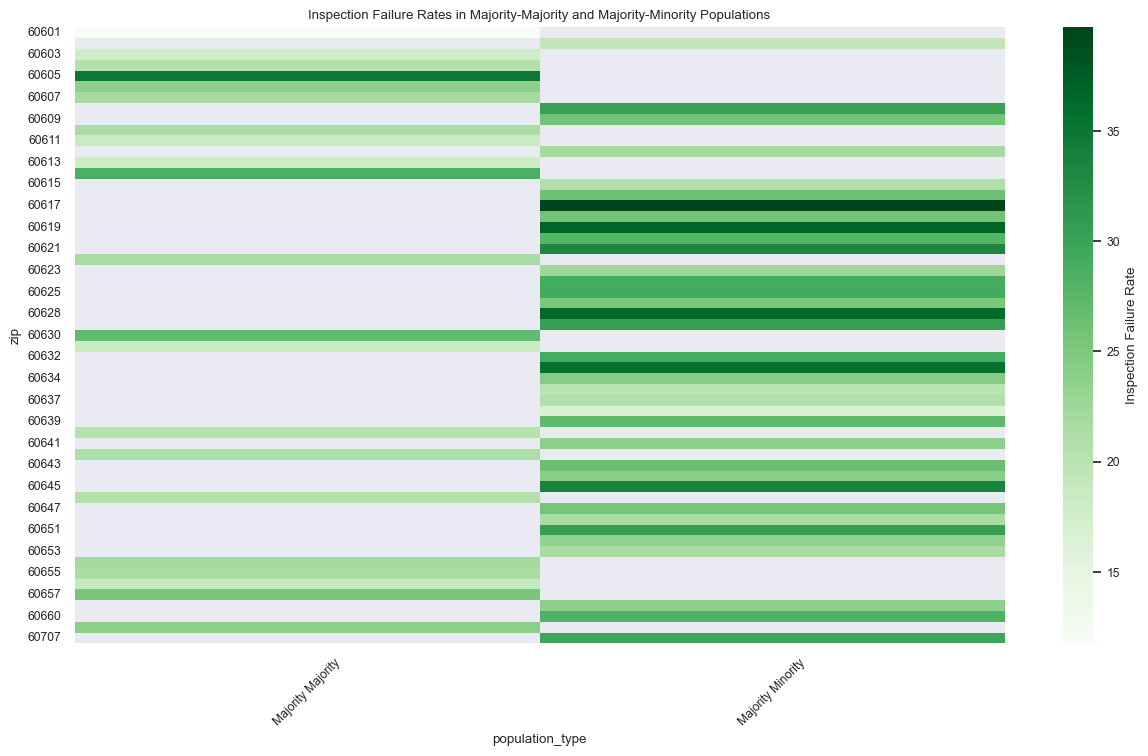

In [131]:
#Creating a heat map that visualizes fail rates across different zip codes for both the majority majority minority populations


#Enhancing readability of the plot since all zipcodes will be displayed
plt.figure(figsize=(15, 8))
sns.set(font_scale=0.8)  
plt.xticks(rotation=45)

#cmap parameter sets the color map to shades of greens
sns.heatmap(concatenated_df.pivot_table(index='zip', columns='population_type', values='Fail'),
            cmap='Greens', annot=False, fmt=".2f", cbar_kws={'label': 'Inspection Failure Rate'})


plt.title('Inspection Failure Rates in Majority-Majority and Majority-Minority Populations')
plt.show()

This heatmap visualizes the inspection failure rates across different zip codes and compares the "majority majority" and "majority minority" populations. More color intensity, or darker green, represents higher fail rates. The color bar on the side provides a reference for the fail rate values.

##### Similarily to what was seen when calculating the differences in pass/fail rates across both groups, this heatmap further emphasizes that inspection failure rates tend to be higher among populations that are comprised of a majority of white non-latinx residents.

##### It is clear that the minority tends to have higher fail rates. I now want to delve into what these inspection outcomes look like within the other demographic groups.

### Inspection Outcomes among specific demographic groups:

1. Latinx
2. Asian non-Latinx
3. Black non-Latinx

##### I want to visualize the linear regression lines of these specific groups and compare them to each other in addition to the trend found with the white non-Latinx population

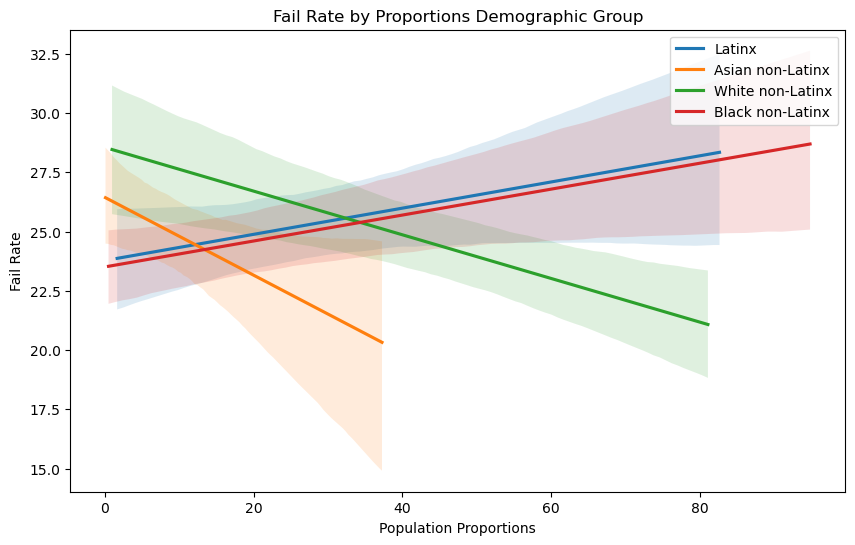

In [95]:
#Creating a plot with regression lines for all listed populations
#Setting scatter to "false" as dots for every zip code will clutter the graph
#Adding labels to the plots in order to differentiate between demographic groups
plt.figure(figsize=(10, 6))
sns.regplot(x='population_latinx', y='Fail', data=inspections_by_zip_demo, scatter=False, label='Latinx')
sns.regplot(x='population_asian_non_latinx', y='Fail', data=inspections_by_zip_demo, scatter=False, label='Asian non-Latinx')
sns.regplot(x='population_white_non_latinx', y='Fail', data=inspections_by_zip_demo, scatter=False, label='White non-Latinx')
sns.regplot(x='population_black_non_latinx', y='Fail', data=inspections_by_zip_demo, scatter=False, label='Black non-Latinx')


plt.xlabel('Population Proportions')
plt.ylabel('Fail Rate')
plt.title('Fail Rate by Proportions Demographic Group')

plt.legend()
plt.show()

#### This plot shows restaurant inspection fail rates for the proportions of poopulations of several demographic groups.

##### The linear regression lines for the Latinx and Black non-Latinx populations have upward sloping trends
1. As a neighborhood has a higher proportion of Latinx residents, the rate of failure increases. 
2. Similarily, as a neighborhood has a higher proportion of Black non-Latinx residents, the rate of failure increases.

##### The linear regression lines for the Asian non-LatinX population and White non-Latinx population have downward sloping trends.
3. As a neighborhood has a higher proportion of Asian non-Latinx residents, rate of failure may decrease. *I was not expecting this result. This suggests that there may be conditions that contirbute to better inspection outcomes in neighborhoos with a higher proportion of Asian non-Latinx residents.*

4. (Previously determined): As a neighborhood has a higher proportion of white non-Latinx residents, rate of failure may decrease,


### It is clear that there *are* systematic differences in food inspection ratings in neighborhoods with a higher proportion of non-white residnets. 

# Discussion of Results

### Answer for RQ1: 
**There are systematic differences in food inspection ratings in neighborhoods with a higher proportion of non-white residents**.The analysis indicates correlations between demographic factors and restaurant inspection outcomes, revealing pass and fail rates associated with different racial and ethnic groups.

After merging dataframes that combined restaurant inspection outcomes by zip code and demographic information by zip code, several insights were revealed that led to this answer. The first trend that emerged indicates that neighborhoods with a higher proportion of White non-Latinx residents tend to have a higher rate of restaurants passing inspections. Similarly, as the proportion of White non-Latinx residents in a neighborhood decreases, the rate of failure decreases. This finding further motivated the exploration to break down demographic groups even further.

When looking at the relationship of the Latinx population and inspection rates through a scatter plot, a slightly upward trend and positive coefficient indicated that failure rates increase as the proportion of the Latinx population increases. Similar trends emerged when conducting these analyses for the population of Black non-Latinx residents. These findings raise questions about potential challenges or factors affecting restaurants in areas with higher black non-Latinx and Latinx populations.

Conversely, when analyzing the relationship of Asian non-Latinx population and inspection rates, a negative relationship was observed. As the population rate of Asian non-Latinx residents increases, the inspection fail rate tends to decrease. This finding suggests potential conditions that contribute to better inspection outcomes in neighborhoods with a higher proportion of Asian non-Latinx residents.

***Uncertanties / Limitations / Judgment Calls***

While these findings provide valuable insights that support my research question and show that there are in fact systematic differences in food inspection ratings in neighborhoods with higher proportions of non-White residents, it is important to note that there are additional factors not considered in the dataset that may influence inspection outcomes. The analysis also does not account for socioeconomic factors or specific characteristics of the food establishments that could contribute to a more comprehensive understanding. 

I also made judgment calls throughout the analysis that may affect the results. As described in comments of the code cells when preparing the data, I did not need exact locations (address, latitude, longitude) of food establishments for my analysis. I ropped columns from the inspection dataset that were not necessary. I also found some zip codes that only had few inspections (7), and knew that it was likely that there would be outliers with such a small amount of inspections. This motivated the decision to drop any zip codes from the dataset that had fewer than 10 inspections. The other judgment calls involved the inspection outcomes and identifying which ones were important to focus on for this analysis. Knowing that the research question focuses on inspections that passed and failed, I dropped some entries that did not coincide with either outcome (e.g. ‘out of business', ‘not ready’). After dropping those, I chose to further investigate the ‘Pass’ and ‘Pass w/ Conditions’ outcomes to determine if they should both be treated as the same or different. When analyzing the difference in “passing”  and “passing with condition” rates against proportions of the white non-Latinx populations as well as populations where the majority is composed of the minority (not white non-Latinx residents), I observed that both outcomes followed similar patterns. I decided to group the pass/pass with condition outcomes into one category.  

### Interpretation of Findings

The analysis indicates that neighborhood demographics play a significant role in restaurant inspection outcomes. The positive correlation observed between a higher white non-Latinx population and increased pass/decreased fail rates suggest better overall conditions or compliance with health and safety standards in these neighborhoods. However, it also may indicate racial biases influencing inspection outcomes.

The observed correlations with Latinx and Black non-Latinx populations further highlight potential disparities or challenges that could impact food establishments in those communities. The unexpected downward trend with the Asian non-Latinx population and inspection fail rates prompt further exploration of possible factors contributing to this pattern.

Overall, these findings align with my expectations in some aspects as they emphasize the need for targeted interventions or changes to inspection practices across diverse communities. Although, the unexpected patterns found in this analysis highlight the necessity for a nuanced understanding of demographic factors and inspection outcomes to bring about changes necessary to food inspection practices.


### Impact on Analysis

The findings from RQ1 provide valuable insights that definitely will impact my approach to research questions 2 and 3. 

RQ2 asks about how the risk category assigned to a restaurant relates to the likelihood of receiving violation citations. The analysis of RQ1 could influence the investigation of risk categories in this question as I now plan to conduct a more comprehensive analysis of how risk categories interact with neighborhood characteristics. This may uncover patterns that contribute to violations.

RQ 3 focuses on the relationship between risk category and inspection outcomes varies based on the demographic makeup of neighborhoods. The identified high risk demographic groups in RQ1 guide a focused investigation into whether certain communities are disproportionately affected by specific risk categories. 


The insights from research from RQ1 will inform policy and organization operations of the problem at hand. This initial analysis highlights the existing issue and warrants the need to design more targeted regulations that address disparities identified in high-risk demographic groups. On the organizational level, those involved in food inspections can leverage this information to start thinking about how inspection practices can be changed, allocate resources more effectively, and enhance training for inspectors.  
